Code sourced from: https://blog.devgenius.io/sculpting-language-gpt-2-fine-tuning-with-lora-1caf3bfbc3c6

In [ ]:
!pip install -q transformers
!pip install -q peft
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=1, lora_alpha=1, lora_dropout=0.1
)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=2
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from peft import get_peft_model
model = get_peft_model(model, lora_config)

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",
                                 num_train_epochs=25,)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load model
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# LoRA Config
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],  # Modules to adapt
    lora_dropout=0.1,
    bias="none"
)
lora_model = get_peft_model(model, lora_config)

# Training
trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(output_dir="./results", num_train_epochs=3),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)
trainer.train()


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'train_dataset' is not defined

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")  # Replace "imdb" with your dataset name
train_dataset = dataset["train"]
eval_dataset = dataset["test"]


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch"
    ),
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.get_device_name(0))  # Prints the name of the GPU (if available)

False


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("gpt2", device_map = None)

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

ValueError: Target modules {'value', 'query'} not found in the base model. Please check the target modules and try again.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model Layers:
transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transf

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Full Fine-Tuning - Total Parameters: 124439808, Trainable Parameters: 124439808

Reduction in Trainable Parameters with LoRA: 97.87%


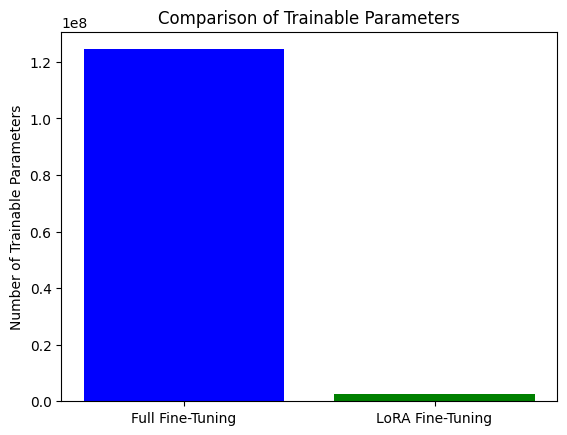

In [ ]:
# Import required libraries
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# Load GPT-2 Model
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=None)  # Using CPU for this example

# Step 1: Inspect Layer Names
print("Model Layers:")
for name, param in model.named_parameters():
    print(name)

# Step 2: Define Valid Target Modules for LoRA (specific to GPT-2)
# Based on the layer names inspected above, use layers like `attn.c_attn` and `mlp.c_fc`.
config = LoraConfig(
    r=32,  # LoRA rank
    lora_alpha=32,  # Scaling factor
    target_modules=["attn.c_attn", "mlp.c_fc"],  # GPT-2 specific layers
    lora_dropout=0.1,  # Dropout probability
    bias="none"  # No bias modification
)

# Step 3: Apply LoRA
lora_model = get_peft_model(model, config)

# Function to count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Count parameters for the LoRA model
total_params, trainable_params = count_parameters(lora_model)
print(f"\nLoRA Model - Total Parameters: {total_params}, Trainable Parameters: {trainable_params}")

# Step 4: Compare with Full Fine-Tuning (Baseline)
# Load the base GPT-2 model again (full fine-tuning setup)
base_model = AutoModelForCausalLM.from_pretrained(model_name)
total_params_full, trainable_params_full = count_parameters(base_model)
print(f"Full Fine-Tuning - Total Parameters: {total_params_full}, Trainable Parameters: {trainable_params_full}")

# Step 5: Compute Reduction
reduction = (1 - trainable_params / trainable_params_full) * 100
print(f"\nReduction in Trainable Parameters with LoRA: {reduction:.2f}%")

# Step 6: Visualization (optional)
import matplotlib.pyplot as plt

# Data for the bar chart
methods = ["Full Fine-Tuning", "LoRA Fine-Tuning"]
trainable_params_data = [trainable_params_full, trainable_params]

# Plotting
plt.bar(methods, trainable_params_data, color=['blue', 'green'])
plt.ylabel("Number of Trainable Parameters")
plt.title("Comparison of Trainable Parameters")
plt.show()


Model Layers:
transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transf

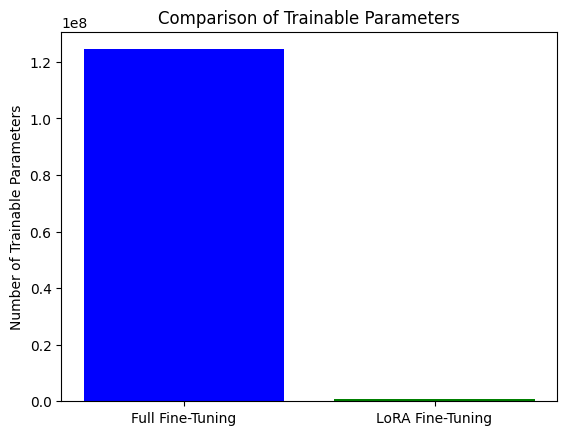

In [ ]:
# Import required libraries
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# Load GPT-2 Model
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=None)  # Using CPU for this example

# Step 1: Inspect Layer Names
print("Model Layers:")
for name, param in model.named_parameters():
    print(name)

# Step 2: Define Valid Target Modules for LoRA (specific to GPT-2)
# Based on the layer names inspected above, use layers like `attn.c_attn` and `mlp.c_fc`.
config = LoraConfig(
    r=10,  # LoRA rank
    lora_alpha=10,  # Scaling factor
    target_modules=["attn.c_attn", "mlp.c_fc"],  # GPT-2 specific layers
    lora_dropout=0.1,  # Dropout probability
    bias="none"  # No bias modification
)

# Step 3: Apply LoRA
lora_model = get_peft_model(model, config)

# Function to count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Count parameters for the LoRA model
total_params, trainable_params = count_parameters(lora_model)
print(f"\nLoRA Model - Total Parameters: {total_params}, Trainable Parameters: {trainable_params}")

# Step 4: Compare with Full Fine-Tuning (Baseline)
# Load the base GPT-2 model again (full fine-tuning setup)
base_model = AutoModelForCausalLM.from_pretrained(model_name)
total_params_full, trainable_params_full = count_parameters(base_model)
print(f"Full Fine-Tuning - Total Parameters: {total_params_full}, Trainable Parameters: {trainable_params_full}")

# Step 5: Compute Reduction
reduction = (1 - trainable_params / trainable_params_full) * 100
print(f"\nReduction in Trainable Parameters with LoRA: {reduction:.2f}%")

# Step 6: Visualization (optional)
import matplotlib.pyplot as plt

# Data for the bar chart
methods = ["Full Fine-Tuning", "LoRA Fine-Tuning"]
trainable_params_data = [trainable_params_full, trainable_params]

# Plotting
plt.bar(methods, trainable_params_data, color=['blue', 'green'])
plt.ylabel("Number of Trainable Parameters")
plt.title("Comparison of Trainable Parameters")
plt.show()


Model Layers:
transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transf

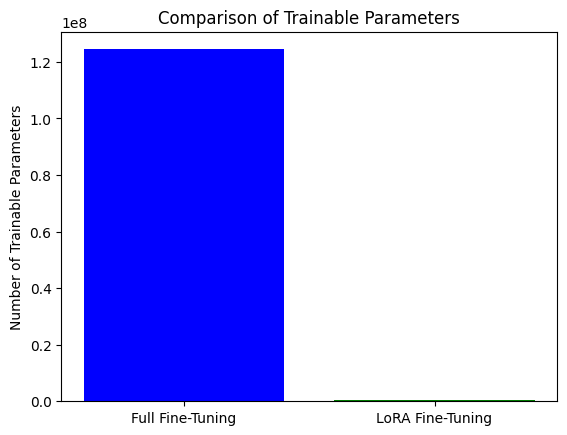

In [ ]:
# Import required libraries
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# Load GPT-2 Model
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=None)  # Using CPU for this example

# Step 1: Inspect Layer Names
print("Model Layers:")
for name, param in model.named_parameters():
    print(name)

# Step 2: Define Valid Target Modules for LoRA (specific to GPT-2)
# Based on the layer names inspected above, use layers like `attn.c_attn` and `mlp.c_fc`.
config = LoraConfig(
    r=5,  # LoRA rank
    lora_alpha=5,  # Scaling factor
    target_modules=["attn.c_attn", "mlp.c_fc"],  # GPT-2 specific layers
    lora_dropout=0.1,  # Dropout probability
    bias="none"  # No bias modification
)

# Step 3: Apply LoRA
lora_model = get_peft_model(model, config)

# Function to count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Count parameters for the LoRA model
total_params, trainable_params = count_parameters(lora_model)
print(f"\nLoRA Model - Total Parameters: {total_params}, Trainable Parameters: {trainable_params}")

# Step 4: Compare with Full Fine-Tuning (Baseline)
# Load the base GPT-2 model again (full fine-tuning setup)
base_model = AutoModelForCausalLM.from_pretrained(model_name)
total_params_full, trainable_params_full = count_parameters(base_model)
print(f"Full Fine-Tuning - Total Parameters: {total_params_full}, Trainable Parameters: {trainable_params_full}")

# Step 5: Compute Reduction
reduction = (1 - trainable_params / trainable_params_full) * 100
print(f"\nReduction in Trainable Parameters with LoRA: {reduction:.2f}%")

# Step 6: Visualization (optional)
import matplotlib.pyplot as plt

# Data for the bar chart
methods = ["Full Fine-Tuning", "LoRA Fine-Tuning"]
trainable_params_data = [trainable_params_full, trainable_params]

# Plotting
plt.bar(methods, trainable_params_data, color=['blue', 'green'])
plt.ylabel("Number of Trainable Parameters")
plt.title("Comparison of Trainable Parameters")
plt.show()


Model Layers:
transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transf

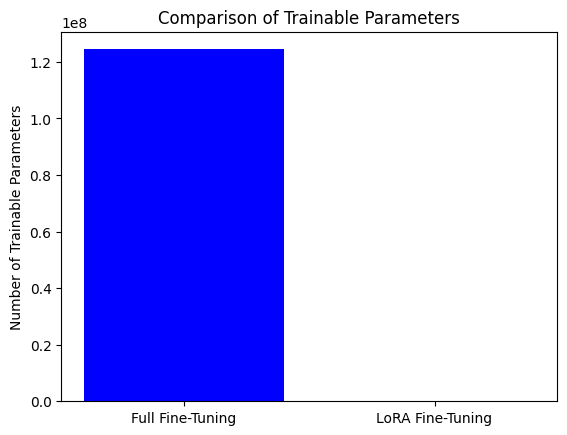

In [ ]:
# Import required libraries
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# Load GPT-2 Model
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=None)  # Using CPU for this example

# Step 1: Inspect Layer Names
print("Model Layers:")
for name, param in model.named_parameters():
    print(name)

# Step 2: Define Valid Target Modules for LoRA (specific to GPT-2)
# Based on the layer names inspected above, use layers like `attn.c_attn` and `mlp.c_fc`.
config = LoraConfig(
    r=1,  # LoRA rank
    lora_alpha=1,  # Scaling factor
    target_modules=["attn.c_attn", "mlp.c_fc"],  # GPT-2 specific layers
    lora_dropout=0.1,  # Dropout probability
    bias="none"  # No bias modification
)

# Step 3: Apply LoRA
lora_model = get_peft_model(model, config)

# Function to count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Count parameters for the LoRA model
total_params, trainable_params = count_parameters(lora_model)
print(f"\nLoRA Model - Total Parameters: {total_params}, Trainable Parameters: {trainable_params}")

# Step 4: Compare with Full Fine-Tuning (Baseline)
# Load the base GPT-2 model again (full fine-tuning setup)
base_model = AutoModelForCausalLM.from_pretrained(model_name)
total_params_full, trainable_params_full = count_parameters(base_model)
print(f"Full Fine-Tuning - Total Parameters: {total_params_full}, Trainable Parameters: {trainable_params_full}")

# Step 5: Compute Reduction
reduction = (1 - trainable_params / trainable_params_full) * 100
print(f"\nReduction in Trainable Parameters with LoRA: {reduction:.2f}%")

# Step 6: Visualization (optional)
import matplotlib.pyplot as plt

# Data for the bar chart
methods = ["Full Fine-Tuning", "LoRA Fine-Tuning"]
trainable_params_data = [trainable_params_full, trainable_params]

# Plotting
plt.bar(methods, trainable_params_data, color=['blue', 'green'])
plt.ylabel("Number of Trainable Parameters")
plt.title("Comparison of Trainable Parameters")
plt.show()



LoRA Model - Total Parameters: 127094016, Trainable Parameters: 2654208
Full Fine-Tuning - Total Parameters: 124439808, Trainable Parameters: 124439808

Reduction in Trainable Parameters with LoRA: 97.87%
LoRA Model - Perplexity: 227.28


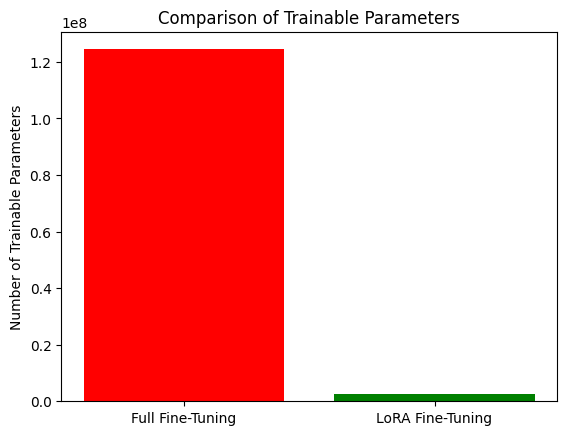

In [4]:
# Import required libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# Load the GPT-2 Tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load GPT-2 Model
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=None)  # Using CPU for this example

# Step 1: Inspect Layer Names (Optional)
# for name, param in model.named_parameters():
#     print(name)

# Step 2: Define Valid Target Modules for LoRA (specific to GPT-2)
config = LoraConfig(
    r=32,  # LoRA rank
    lora_alpha=32,  # Scaling factor
    target_modules=["attn.c_attn", "mlp.c_fc"],  # GPT-2 specific layers
    lora_dropout=0.1,  # Dropout probability
    bias="none"  # No bias modification
)

# Step 3: Apply LoRA
lora_model = get_peft_model(model, config)

# Function to count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Count parameters for the LoRA model
total_params, trainable_params = count_parameters(lora_model)
print(f"\nLoRA Model - Total Parameters: {total_params}, Trainable Parameters: {trainable_params}")

# Step 4: Compare with Full Fine-Tuning (Baseline)
base_model = AutoModelForCausalLM.from_pretrained(model_name)
total_params_full, trainable_params_full = count_parameters(base_model)
print(f"Full Fine-Tuning - Total Parameters: {total_params_full}, Trainable Parameters: {trainable_params_full}")

# Step 5: Compute Reduction
reduction = (1 - trainable_params / trainable_params_full) * 100
print(f"\nReduction in Trainable Parameters with LoRA: {reduction:.2f}%")

# Function to calculate token-level accuracy
def calculate_token_accuracy(model, input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        logits = outputs.logits

    # Get the predicted token (most probable token for each position)
    predicted_ids = torch.argmax(logits, dim=-1)

    # Count how many predictions match the actual tokens
    correct = (predicted_ids == input_ids).sum().item()
    total = input_ids.numel()

    accuracy = correct / total * 100
    return accuracy, outputs.loss.item()

# Test the model with LoRA applied
input_text = "The quick brown fox jumps over the lazy dog"
accuracy, loss = calculate_token_accuracy(lora_model, input_text)
perplexity = torch.exp(torch.tensor(loss))

# print(f"\nLoRA Model - Token-Level Accuracy: {accuracy:.2f}%")
print(f"LoRA Model - Perplexity: {perplexity.item():.2f}")

# Step 6: Visualization (optional)
import matplotlib.pyplot as plt

# Data for the bar chart
methods = ["Full Fine-Tuning", "LoRA Fine-Tuning"]
trainable_params_data = [trainable_params_full, trainable_params]

# Plotting
plt.bar(methods, trainable_params_data, color=['red', 'green'])
plt.ylabel("Number of Trainable Parameters")
plt.title("Comparison of Trainable Parameters")
plt.show()
